In [1]:
!pip install transformers torch
!pip install tensorflow tensorflow-hub

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
from bs4 import BeautifulSoup

import shutil

import gensim
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModel

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score

import tensorflow_hub as hub
import tensorflow as tf

import pickle

In [3]:
df = pd.read_csv('/kaggle/input/bigot-benjamin-1-notebook-exploration-022025/preprocessed_data.csv')
display(df.head())

,Id,Title,Body,Tags,Score,ViewCount,AnswerCount,CreationDate,Processed
0,75956209,"Error ""'DataFrame' object has no attribute 'ap...",<p>I am trying to append a dictionary to a Dat...,<python><pandas><dataframe><concatenation><att...,312,692073,3,2023-04-07 07:05:59,"['error', 'object', 'attribute', 'append', 'tr..."
1,75898276,"OpenAI API error 429: ""You exceeded your curre...",<p>I'm making a Python script to use OpenAI vi...,<python><prompt><openai-api><completion><chatg...,169,416362,5,2023-03-31 11:58:04,"['api', 'error', 'exceed', 'quota', 'check', '..."
2,77171270,Compilation error after upgrading to JDK 21 - ...,"<p>After upgrading to JDK 21, I have the follo...",<spring-boot><compiler-errors><upgrade><lombok...,358,396585,13,2023-09-25 09:05:11,"['compilation', 'error', 'upgrade', 'upgrade',..."
3,76435306,"babel-preset-react-app, is importing the ""@bab...",<p>My issue is that I've tried to create a new...,<javascript><node.js><reactjs><babeljs><ejs>,155,273911,24,2023-06-08 19:56:44,"['react', 'app', 'import', 'babel', 'plugin', ..."
4,76303988,"""ERROR: File xxx can't be indexed twice."" when...",<p>Below is my Azure pipeline to analyze a sol...,<c#><c++><sonarqube><sonarqube-scan><sonar-run...,0,208657,1,2023-05-22 07:45:00,"['error', 'file', 'index', 'analyze', 'solutio..."


In [4]:
import re

df["Tags"] = df["Tags"].apply(lambda x: re.findall(r'<(.*?)>', x))

display(df.head())

,Id,Title,Body,Tags,Score,ViewCount,AnswerCount,CreationDate,Processed
0,75956209,"Error ""'DataFrame' object has no attribute 'ap...",<p>I am trying to append a dictionary to a Dat...,"[python, pandas, dataframe, concatenation, att...",312,692073,3,2023-04-07 07:05:59,"['error', 'object', 'attribute', 'append', 'tr..."
1,75898276,"OpenAI API error 429: ""You exceeded your curre...",<p>I'm making a Python script to use OpenAI vi...,"[python, prompt, openai-api, completion, chatg...",169,416362,5,2023-03-31 11:58:04,"['api', 'error', 'exceed', 'quota', 'check', '..."
2,77171270,Compilation error after upgrading to JDK 21 - ...,"<p>After upgrading to JDK 21, I have the follo...","[spring-boot, compiler-errors, upgrade, lombok...",358,396585,13,2023-09-25 09:05:11,"['compilation', 'error', 'upgrade', 'upgrade',..."
3,76435306,"babel-preset-react-app, is importing the ""@bab...",<p>My issue is that I've tried to create a new...,"[javascript, node.js, reactjs, babeljs, ejs]",155,273911,24,2023-06-08 19:56:44,"['react', 'app', 'import', 'babel', 'plugin', ..."
4,76303988,"""ERROR: File xxx can't be indexed twice."" when...",<p>Below is my Azure pipeline to analyze a sol...,"[c#, c++, sonarqube, sonarqube-scan, sonar-run...",0,208657,1,2023-05-22 07:45:00,"['error', 'file', 'index', 'analyze', 'solutio..."


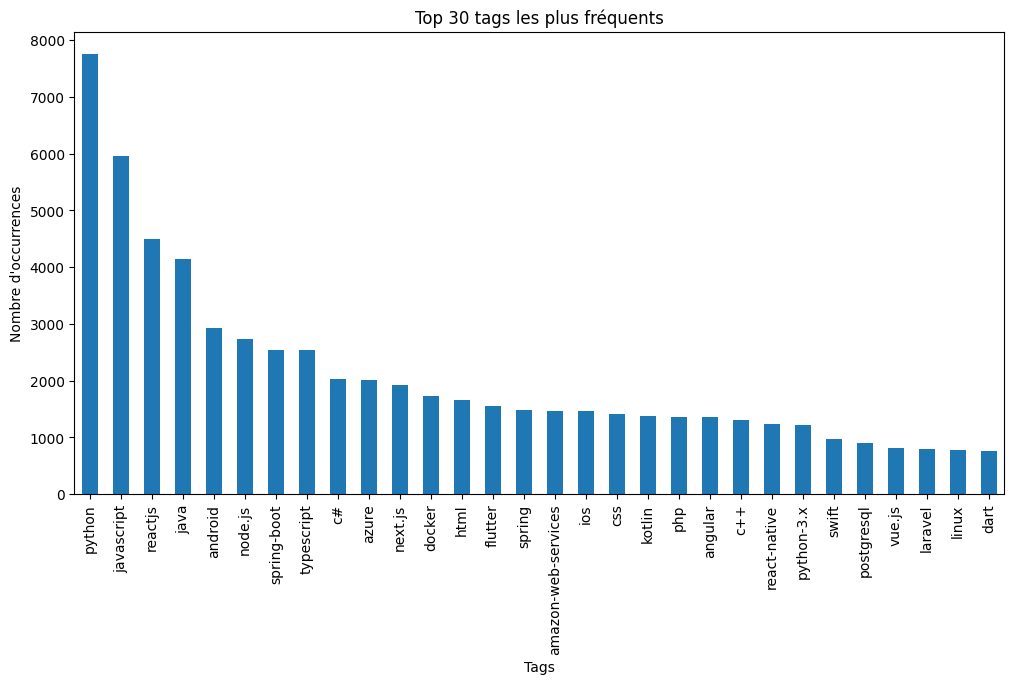

In [5]:
tags_exploded = df["Tags"].explode()

distribution = tags_exploded.value_counts()

top_30_tags = distribution.head(30)

plt.figure(figsize=(12, 6))
top_30_tags.plot(kind="bar")
plt.title("Top 30 tags les plus fréquents")
plt.xlabel("Tags")
plt.ylabel("Nombre d'occurrences")
plt.show()

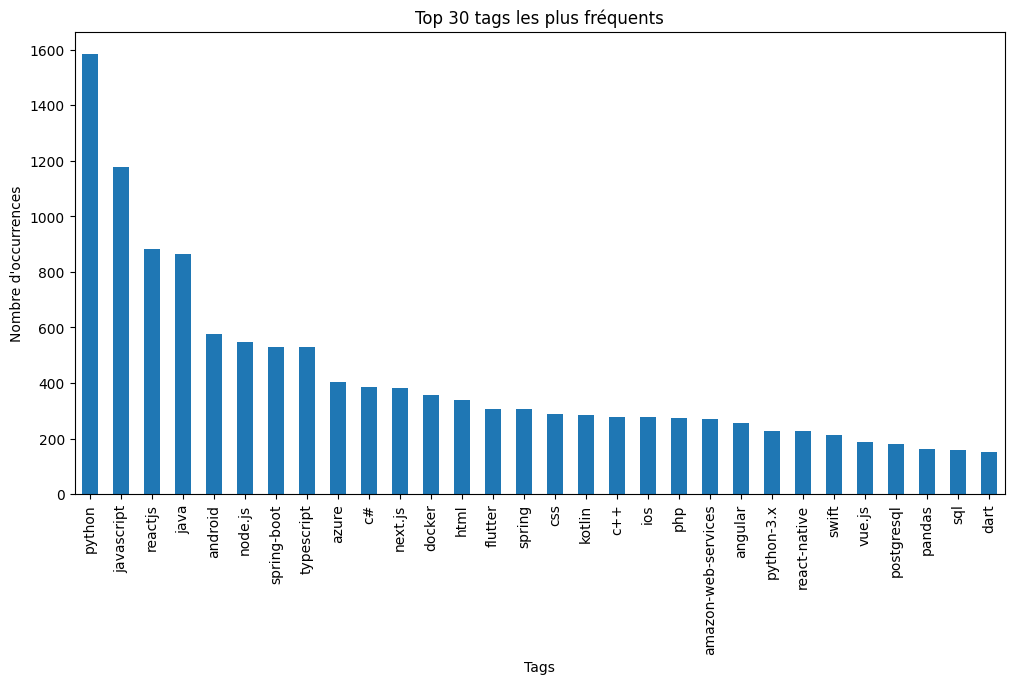

In [6]:
data = df.sample(n=10000, random_state=42)

tags_exploded = data["Tags"].explode()

distribution = tags_exploded.value_counts()

top_30_tags = distribution.head(30)

plt.figure(figsize=(12, 6))
top_30_tags.plot(kind="bar")
plt.title("Top 30 tags les plus fréquents")
plt.xlabel("Tags")
plt.ylabel("Nombre d'occurrences")
plt.show()

In [7]:
def preprocess_text(text):
    return simple_preprocess(text)

In [8]:
def remove_html_tags(text):
    """
    Supprime les balises HTML d'une chaîne de caractères
    et renvoie le texte brut.
    """
    return BeautifulSoup(text, "html.parser").get_text()

In [9]:
X = (data['Title'] + " " + data['Body']).apply(preprocess_text)
y = data["Tags"]

X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

# Vérifier la taille des jeux de données
print(f"Taille du train : {len(X_train)}")
print(f"Taille du test : {len(X_test)}")

Taille du train : 8000
Taille du test : 2000


In [10]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train_raw)
y_test = mlb.transform(y_test_raw)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['4g', '64-bit', '8thwall-web', 'a-star', 'abort', 'accelerate', 'acceptance-testing', 'access-violation', 'activation-function', 'activesupport-concern', 'adaptive-cards', 'add-filter', 'adminer', 'ado', 'aforge', 'aframe', 'ag-charts-react', 'aggregate-filter', 'aggregate-functions', 'aiven', 'ajaxform', 'alarmmanager', 'alchemy', 'alpha-transparency', 'alter', 'amazon-efs', 'amazon-fsx', 'amazon-kinesis-firehose', 'amazon-redshift-spectrum', 'amazon-sagemaker-studio', 'amazon-textract', 'analysis', 'android-architecture-navigation', 'android-auto', 'android-automotive', 'android-billing', 'android-compose-image', 'android-developer-api', 'android-firmware', 'android-management-api', 'android-networking', 'android-volley', 'angular-control-flow', 'angular-formly', 'angular-http-interceptors', 'angular9', 'anonymousidentification', 'anthropic', 'apache-axis', 'apache-commons-dbc

In [11]:
tag_frequencies = np.sum(y_train, axis=0)

sorted_indices = np.argsort(-tag_frequencies)

cumulative_coverage = np.cumsum(tag_frequencies[sorted_indices]) / np.sum(tag_frequencies)
N_optimal = np.argmax(cumulative_coverage >= 0.80) + 1 

In [12]:
N = N_optimal

selected_tags = sorted_indices[:N]

y_train = y_train[:, selected_tags]
y_test = y_test[:, selected_tags]

mlb_filtered = MultiLabelBinarizer(classes=mlb.classes_[selected_tags])
mlb_filtered.fit([selected_tags])

print(f"Nombre optimal de tags conservés : {N}")
print("Tags les plus fréquents :", mlb_filtered.classes_)

Nombre optimal de tags conservés : 1906
Tags les plus fréquents : ['python' 'javascript' 'reactjs' ... 'quic' 'apple-developer' 'appkit']


In [13]:
print(y_train.shape)
print(y_test.shape)

(8000, 1906)
(2000, 1906)


# WORD2VEC

In [14]:
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100

print("Entraînement du modèle Word2Vec...")
w2v_model = Word2Vec(
    sentences=X_train,
    vector_size=w2v_size,
    window=w2v_window,
    min_count=w2v_min_count,
    epochs=w2v_epochs,
    seed=42
)

# Le modèle est maintenant entraîné et chaque mot du vocabulaire possède un vecteur
print("Taille du vocabulaire :", len(w2v_model.wv.index_to_key))

Entraînement du modèle Word2Vec...
Taille du vocabulaire : 85577


In [15]:
def vectorize_sentence(sentence, model):
    # sentence doit être une liste de tokens
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        # Retourne un vecteur nul si aucun mot n'est connu
        return np.zeros(model.vector_size)

In [16]:
X_train_w2v = np.array([vectorize_sentence(sentence, w2v_model) for sentence in X_train])
X_test_w2v = np.array([vectorize_sentence(sentence, w2v_model) for sentence in X_test])

print("Forme des embeddings d'entraînement :", X_train_w2v.shape)
print("Forme des embeddings de test :", X_test_w2v.shape)

Forme des embeddings d'entraînement : (8000, 300)
Forme des embeddings de test : (2000, 300)


In [17]:
df_train_w2v = pd.DataFrame(X_train_w2v)
df_test_w2v = pd.DataFrame(X_test_w2v)

# Sauvegarder sous forme de CSV
df_train_w2v.to_csv("X_train_W2V.csv", index=False)
df_test_w2v.to_csv("X_test_W2V.csv", index=False)

# BERT

In [18]:
data["Title_clean"] = data["Title"].apply(remove_html_tags)
data["Body_clean"] = data["Body"].apply(remove_html_tags)
data["Text"] = data["Title_clean"] + " " + data["Body_clean"]
texts = data["Text"].tolist()

<ipython-input-8-036ac7904277>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


In [19]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Envoyer le modèle sur le GPU si disponible, sinon sur le CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [20]:
def encode_batch(texts, tokenizer, model, device, batch_size=16):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        # Tokenisation avec padding et troncature
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs = {key: val.to(device) for key, val in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Extraire l'embedding du token [CLS]
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # shape (batch_size, hidden_size)
        all_embeddings.append(cls_embeddings.cpu().numpy())
    
    # Concaténer les embeddings de tous les lots
    return np.concatenate(all_embeddings, axis=0)

# Encodage des textes
embeddings = encode_batch(texts, tokenizer, model, device, batch_size=8)
print("Shape des embeddings:", embeddings.shape)

Shape des embeddings: (10000, 768)


In [21]:
X_train_bert, X_test_bert = train_test_split(embeddings, test_size=0.2, random_state=42)

df_train_bert = pd.DataFrame(X_train_bert)
df_test_bert = pd.DataFrame(X_test_bert)

# Sauvegarder sous forme de CSV
df_train_bert.to_csv("X_train_bert.csv", index=False)
df_test_bert.to_csv("X_test_bert.csv", index=False)

# USE

In [22]:
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [23]:
# Appliquer USE pour obtenir les embeddings
embeddings = use_model(texts)
# Convertir en tableau NumPy
embeddings = embeddings.numpy()

print("Shape des embeddings :", embeddings.shape)

Shape des embeddings : (10000, 512)


In [24]:
X_train_use, X_test_use = train_test_split(embeddings, test_size=0.2, random_state=42)

df_train_use = pd.DataFrame(X_train_use)
df_test_use = pd.DataFrame(X_test_use)
df_y_train = pd.DataFrame(y_train)
df_y_test = pd.DataFrame(y_test)

# Sauvegarder sous forme de CSV
df_train_use.to_csv("X_train_use.csv", index=False)
df_test_use.to_csv("X_test_use.csv", index=False)

df_y_train.to_csv("y_train.csv", index=False)
df_y_test.to_csv("y_test.csv", index=False)

In [25]:
df_X_test = pd.DataFrame(X_test)
df_X_train = pd.DataFrame(X_train)

df_X_test.to_csv("X_test.csv", index=False)
df_X_train.to_csv("X_train.csv", index=False)

In [26]:
# Sauvegarder le MultiLabelBinarizer
with open("mlb.pkl", "wb") as f:
    pickle.dump(mlb_filtered, f)

print("✅ MLB exporté avec succès !")

✅ MLB exporté avec succès !
